# Notebook 4: Inhomogeneous Poisson Process

Computational Biology 2 - WS 23/24

Material created by Katharina Bracher and Florian Eberhardt


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Problem 1: 

Can you judge whether the analzed spike trains of yesterday's notebook (Problems 1-3) are generated from a homogenous Poisson process? Explain.

In [2]:
with np.load('./spiketrains.npz', allow_pickle=True) as data:
    spikes1 = data['spikes3_0'].tolist()
    spikes2 = data['spikes7_5'].tolist()

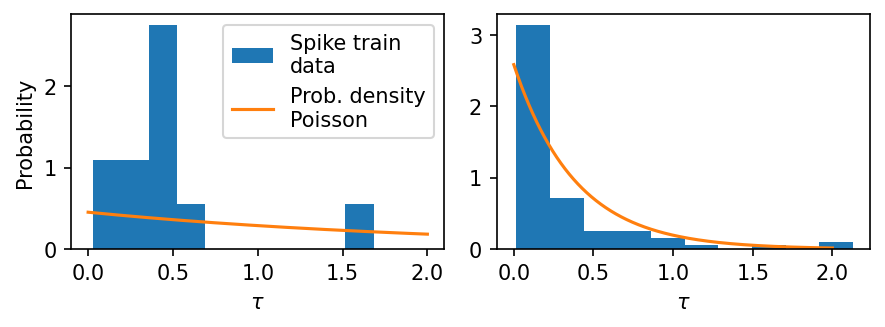

In [3]:
# comput Fano factor, CV 
# show histogram of ISIs and compare it the the theoretically predicted densitiy function 
# of a homogenous Poisson proccess with the identical rate.

t_max_1 = 3.0
t_max_2 = 7.5

isis1 = []
counts1 = []
for i, st in enumerate(spikes1):
    isis1.append(np.diff(st))
    counts1.append(len(st))
isis1 = np.concatenate(isis1)
    
isis2 = []
counts2 = []
for i, st in enumerate(spikes2):
    isis2.append(np.diff(st))
    counts2.append(len(st))
isis2 = np.concatenate(isis2)

# number of spikes in all trials  / (duration of a trial * number of trials )
rate1 = np.concatenate(spikes1).size / (t_max_1 * len(spikes1) )
rate2 = np.concatenate(spikes2).size / (t_max_2 * len(spikes2) )

fig = plt.figure(dpi=150)
ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222)

# 
ax1.hist(isis1, density=True, linewidth=1, label='Spike train\ndata')
ax2.hist(isis2, density=True)
t = np.linspace(0.,2.,1000)
f_tau_1 = rate1 * np.exp(-rate1*t)
f_tau_2 = rate2 * np.exp(-rate2*t)
ax1.plot(t,f_tau_1, label='Prob. density\nPoisson ')
ax2.plot(t,f_tau_2)

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\tau$')
ax1.set_ylabel('Probability')
ax1.legend()

plt.tight_layout()

In [4]:
print('Spike trains 1:')
print('CV:', isis1.std(ddof=1)/isis1.mean())
print('Fano factor:', np.var(counts1, ddof=1)/np.mean(counts1))

print('Spike trains 2:')
print('CV:', (isis2.std(ddof=1)/isis2.mean()))
print('Fano factor:', np.var(counts2, ddof=1)/np.mean(counts2))


Spike trains 1:
CV: 0.9702139013231663
Fano factor: 2.336032388663967
Spike trains 2:
CV: 1.3181676786846812
Fano factor: 1.7680412371134024


---
### Problem 2: Refractory Period 

The Poisson process is not an accurate representation of the spiking statistics in the brain. One biologically implausible property is that the intervals between spikes cannot be arbitrarily short. Real neurons, after generating a spike, remain unresponsive for some time, called a refractory period, during which the ion channels and membrane potential recover to their resting state.

Take yesterday's `poissonspikes_ISI` function to generate a homogenous poisson spike train. Get the ISIs for the spike train. You can do this by adapting the function to e.g. return the spike train and the list of ISIs  (remeber that we used the ISI distribution to generate the spike train) or after via `np.diff`. 

In [5]:
def poisson_spikes_ISI(rate, time):
    spikes = []
    t = 0
    while t < time:
        t -= np.log(np.random.rand())/rate
        spikes.append(t)
    isis = np.diff(spikes)
    return spikes[:-1], np.array(isis[:-1])

def poisson_refractory_spikes_ISI_biased(rate, time, refractory_period):
    spikes = []
    t = 0
    while t < time:
        #t = t - np.log(np.random.rand())/rate+refractory_period
        t -=  np.log(np.random.rand())/rate-refractory_period
        spikes.append(t)
    isis = np.diff(spikes)
    return spikes[:-1], np.array(isis[:-1])

### Alternative solution to Problem 2:
We can emulate the refractory period in the Poisson process (function without refractory period) by adding this period to all generated inter-spike intervals in.

In [6]:
rate = 100 # Hz
time = 1
refractory_period = 0.008 # 8 ms

spiketrain, isi = poisson_spikes_ISI(rate, time)
isi_ref = isi + refractory_period

### Problem 3:
Now compare the statistics (firing rate and minimum inter-spike interval) of the Poisson process and the same process with refractory period. Use the ISIs instead of the spike train to estimate the rate. To estimate the rate from the ISI simply divide the number of spikes (number of ISIs + 1) by the time of the spike train (sum of ISIs). What do you notice?

In [7]:
spiketrain, isi = poisson_spikes_ISI(rate, time)
spiketrain_ref, isi_ref = poisson_refractory_spikes_ISI_biased(rate, time, 0.008)

In [8]:
def estimate_rate_from_isi(isi):
    return (len(isi)+1)/(np.sum(isi))

In [9]:
print("Refractory period:", refractory_period*1000, 'ms')
print("Minimum inter-spike interval:")
print(" - Poisson process: {:.6f} ms".format(isi.min()))
print(" - Poisson with ref. period: {:.3f} ms".format(isi_ref.min()*1000))
print('Firing rate:')
print(" - Poisson process: {:.3f} Hz".format(estimate_rate_from_isi(isi)))
print(" - Poisson with ref. period: {:.3f} Hz".format(estimate_rate_from_isi(isi_ref)))

Refractory period: 8.0 ms
Minimum inter-spike interval:
 - Poisson process: 0.000008 ms
 - Poisson with ref. period: 8.096 ms
Firing rate:
 - Poisson process: 103.902 Hz
 - Poisson with ref. period: 49.744 Hz


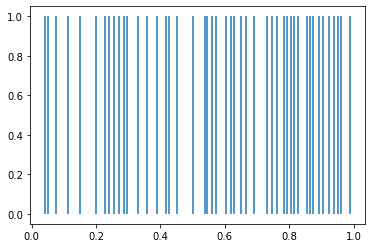

In [10]:
plt.vlines(spiketrain_ref[:100],0,1)

### Explanation

Note that by increasing the inter-spike intervals we decreased the rate $r$. The new firing rate $\hat{r}$ can be calculated from the equation with the refractory period $\tau_{\mathrm{ref}}$:

$$r=\left(\hat{r}^{-1}+\tau_{\mathrm{ref}}\right)^{-1}$$

To compensate for the decrease, we need to increase the rate parameter $r$ in our `poisson_spikes_ISI` function. If we solve the above equation for $\hat{r}$ we obtain the adapted rate parameter:

$$\hat{r}=\left(r^{-1}-\tau_{\mathrm{ref}}\right)^{-1}$$


### Problem 4:
We now implement this correction in a function generating inter-spike intervals with refractory period: `poisson_refractory_spikes_ISI` by adpation the function above (`poisson_refractory_spikes_ISI_biased`).

Are there limits for the rate the new function can take as an argument?

In [14]:
def poisson_refractory_spikes_ISI(rate, time, refractory_period):
    rate = 1/(1/rate-refractory_period)
    spikes = []
    isis = []
    t = 0
    while t < time:
        isi = -np.log(np.random.rand())/rate+refractory_period
        t = t + isi
        spikes.append(t)
        isis.append(isi)
    return spikes[:-1], np.array(isis[:-1])

Check whether after this modification the expected firing rate and inter-spike intervals are correct:

In [17]:
rate = 100 # Hz
time = 10
refractory_period = 0.008 # 8 ms

spiketrain_ref, isi_ref = poisson_refractory_spikes_ISI(rate, 10, refractory_period)
print("Minimum inter-spike interval: {:.1f} ms".format(isi_ref.min()*1000))
print('Firing rate: {:.1f} Hz'.format(estimate_rate_from_isi(isi_ref)))

Minimum inter-spike interval: 8.0 ms
Firing rate: 99.7 Hz


### Problem 5
Plot a raster plot of a Poisson process with and without refractory period. What do you notice?

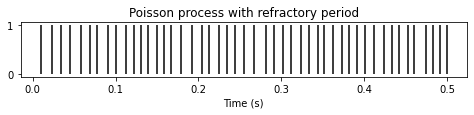

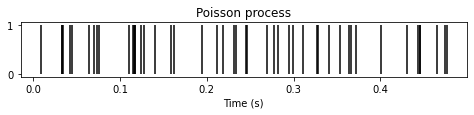

In [20]:
time=0.5
rate=100
refractory_period = 0.008


spike_train_ref, isi_ref = poisson_refractory_spikes_ISI(rate, time, refractory_period)

plt.figure(figsize=(8,1))
plt.vlines(spike_train_ref, ymin=0, ymax=1, color='k')
plt.xlabel('Time (s)')
plt.title('Poisson process with refractory period')
plt.show()


spiketrain, isi = poisson_spikes_ISI(rate, time)

plt.figure(figsize=(8,1))
spike_train = np.cumsum(isi)
plt.vlines(spike_train, ymin=0, ymax=1, color='k')
plt.xlabel('Time (s)')
plt.title('Poisson process')
plt.show()

### Problem 6
Which ratio helps you to quantify your observation? Calculate it for the spike train with refractoriness. What do you notice if you compare to a normal poisson spike train?

In [21]:
def calc_cv(isi):
    return np.std(isi)/np.mean(isi)
print("CV with refractory period: {:.1f}".format(calc_cv(isi_ref)))

CV with refractory period: 0.2


This value is much lower than the CV of the Poisson distribution (equal to 1), which is a sign that a process with refractory period is in fact more regular. This is also visible in the raster plot:

---
###  Inhomogeneous Poisson process

So far we only considered processes with a constant rate (no variations over time). However, in nervous system the information about external stimuli is encoded in temporal variations of neuronal activity. 

We can now replace the constant firing rate with an array of firing rates, one value per a bin. For example, we can generate a firing rate oscillating at a frequency of 1 Hz:

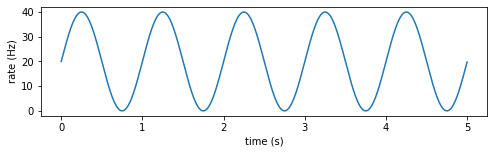

In [22]:
time = 5
max_rate = 40
f_osc = 1
dt = 0.002
times = np.arange(0, time, dt)
rate = max_rate * (np.sin(2*np.pi*f_osc*times)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(times, rate)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

### Problem 7
Write a function that takes a rate and returns spike times based on a inhomogenous Poisson Process. 

Go back to the function we implemented yesterday: `homogeneous_poisson` (also below).

Replace the rate value by an array and compare each random number to consecutive elements of the array. The comparison operators defined in `numpy` work transparently both for single values and arrays, so we do not have to modify the code. We can skip the `time` argument of the function (duration of the train), because it can be obtained directly from the length of the rate array. Don't forget to convert the binary spike train to spike times (__hint__: `np.nonzero`).

In [23]:
def homogeneous_poisson(rate, time, dt):
    times = np.arange(0, time, dt)
    spikes = np.random.rand(times.size) < rate * dt
    return times, spikes

In [24]:
def inhomogeneous_poisson(rate, dt):
    n_bins = len(rate)
    times = np.arange(0, n_bins*dt+dt, dt)
    spikes = np.random.rand(n_bins) < rate * dt
    spike_times = np.nonzero(spikes)[0] * dt
    isis = np.diff(spike_times)
    return times,spike_times,isis

In [25]:
# example
spikes = np.random.rand(20) < rate[:20] * 0.001
spikes

array([ True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False])

In [26]:
# example
np.nonzero(spikes)[0] * 0.001

array([0.  , 0.01])

### Problem 8
Simulate 100 trials with the oscillatory rate as shown above and plot them as a raster. 

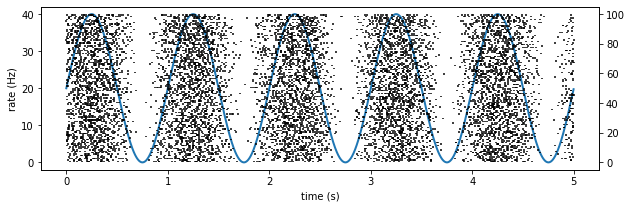

In [27]:

trials=100

plt.figure(figsize=(10,3))
plt.plot(times, rate, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
plt.twinx()
for i, run in enumerate(range(trials)):
    _,poisson_spike_times, isis = inhomogeneous_poisson(rate, dt)
    plt.vlines(poisson_spike_times, i, i+1, color='k')

From the raster plot you can see how the spikes are modulated in time. The spike density follows the time-dependent rate superimposed on the plot (blue).

### Problem 9
Calculate the coefficient of variation for one of the trials. What do you notice?

In [28]:
poisson_isis = np.diff(poisson_spike_times)
print('CV:', poisson_isis.std()/poisson_isis.mean())

CV: 1.5854830853220834


CV of the inhomogeneous Poisson process is higher than 1 indicating that it is more irregular than the homogeneous instance.

### To summarize:

* CV = 1 - spike train regularity equal to that of the Poisson process,
* CV < 1 - more regular than the Poisson process (for example due to refractoriness),
* CV > 1 - less regular than the Poisson process (for example due to variations of firing rate or burstiness).

Adpated from \
Bartosz Telenczuk, 2017. Python in neuroscience - tutorials. Zenodo. doi:10.5281/zenodo.345422